In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import pandas as pd
import numpy as np

In [2]:
class AudioClassifyDataset(Dataset):
    def __init__(self, root="./UrbanSound8K/"):
        
        self.data = []
        self.label = []
        
        FRAME_SIZE = 512
        HOP_SIZE = 512
        target_length = 88200
        
        meta = pd.read_csv(root+"/metadata/UrbanSound8K.csv")
        
        for fold in os.listdir(root+"audio/")[0:2]:
            if fold[0] == '.':
                continue
            print(fold)

            for file in tqdm(os.listdir(root+"audio/"+fold+"/")[1:11]):
                if file[0] == '.':
                    continue

                PATH = root+"audio/"+fold+"/"+file
                sig, sr = librosa.load(PATH)
                sig = librosa.util.fix_length(sig, target_length)

                S_scale = librosa.stft(sig, win_length=HOP_SIZE, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
                Y_scale = abs(S_scale)**2
                Y_db = librosa.power_to_db(Y_scale)
                
                
                Y_db = np.expand_dims(Y_db, axis=0)
                
                #plot_spectrogram(sig, Y_db, sr, HOP_SIZE)
                
                idx = np.where(meta['slice_file_name'] == file)[0][0]
                label = meta.iloc[[idx]]['classID'][idx]
                
                self.data.append(Y_db)
                self.label.append(label)

    def __len__(self):
        assert(len(self.data) == len(self.label))
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [32]:
def eval_model(model, test_data):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        corr_pred = 0
        total_samples = 0

        for data, label in tqdm(test_data):

            data = data.to(device)
            label = label.to(device)

            outputs = model(data)
            loss = criterion(outputs, label) # calculate the loss

            corr_pred += (outputs.argmax(dim=1) == label).sum()
            total_samples += len(label)

            epoch_loss += loss.item()
        
    return epoch_loss / len(test_data), corr_pred / total_samples
    

In [84]:
class AudioCnn(nn.Module):
    def __init__(self):
        super(AudioCnn, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7, padding=3)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=2)
        self.conv_3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(16 * 32 * 21, 512)
        self.fc2 = nn.Linear(512, 10)
        
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.drop = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm2d(num_features=16)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool(x)
        
        x = self.conv_2(x)
        x = self.pool(x)
        
        x = self.conv_3(x)
        x = self.pool(x)
        x = self.norm(x)
        
        x = x.view(-1, 32 * 21 * 16)
        x = self.relu(x)
        #x = self.drop(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        return x
    

In [87]:
test_percent = 0.2
batch_size = 32

audio_dataset = torch.load("./audio_dataset")
data_length = len(audio_dataset)

test_length = int(0.2 * data_length)
train_length = data_length - test_length

data_loader = DataLoader(dataset=audio_dataset, batch_size=batch_size, shuffle=True)

train_indices, test_indices = random_split(range(data_length), [train_length, test_length])
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_data = DataLoader(dataset=audio_dataset, batch_size=batch_size, sampler=train_sampler)
test_data = DataLoader(dataset=audio_dataset, batch_size=batch_size, sampler=test_sampler)


In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = AudioCnn().to(device)
criterion = nn.CrossEntropyLoss()        
optimizer = torch.optim.Adam(model.parameters())

cuda:0


In [107]:
num_epochs = 10
test_losses = []
train_losses = []

test_accuracy = []
train_accuracy = []

test_loss, test_acc = eval_model(model=model, test_data=test_data)
print("Epoch #{} === test loss: {:.2f}, test accuracy: {:.2f}".format(0, test_loss, test_acc*100))

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    total_samples = 0
    corr_pred = 0
    
    for data, label in tqdm(train_data):
        
        data = data.to(device)
        label = label.to(device)
        
        total_samples += len(label)
        
        outputs = model(data)
        
        corr_pred += (outputs.argmax(dim=1) == label).sum()
        
        loss = criterion(outputs, label) # calculate the loss
        
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        
        epoch_loss += loss.item()
        
    model.eval()
    test_loss, test_acc = eval_model(model=model, test_data=test_data)
    test_acc *= 100
    
    epoch_loss /= len(train_data)
    epoch_accuracy = 100 * corr_pred / total_samples
    
    print("Epoch #{} === train loss: {:.2f}, test loss: {:.2f}".format(epoch+1, epoch_loss, test_loss))
    print("Epoch #{} === train accuracy: {:.2f}, test accuracy: {:.2f}".format(epoch+1, epoch_accuracy, test_acc))
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    
    train_accuracy.append(epoch_accuracy)
    test_accuracy.append(test_acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 62.95it/s]


Epoch #0 === test loss: 2.30, test accuracy: 14.49


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 48.71it/s]


Epoch #1 === train loss: 1.24, test loss: 0.95
Epoch #1 === train accuracy: 60.64, test accuracy: 68.10


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 52.65it/s]


Epoch #2 === train loss: 0.54, test loss: 1.51
Epoch #2 === train accuracy: 82.45, test accuracy: 57.45


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 50.42it/s]


Epoch #3 === train loss: 0.26, test loss: 0.57
Epoch #3 === train accuracy: 91.87, test accuracy: 81.73


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 51.66it/s]


Epoch #4 === train loss: 0.14, test loss: 0.65
Epoch #4 === train accuracy: 95.83, test accuracy: 81.44


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 51.71it/s]


Epoch #5 === train loss: 0.08, test loss: 0.88
Epoch #5 === train accuracy: 97.44, test accuracy: 78.58


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 52.76it/s]


Epoch #6 === train loss: 0.05, test loss: 0.74
Epoch #6 === train accuracy: 98.81, test accuracy: 82.19


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 50.07it/s]


Epoch #7 === train loss: 0.06, test loss: 0.74
Epoch #7 === train accuracy: 98.38, test accuracy: 82.76


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 54.68it/s]


Epoch #8 === train loss: 0.07, test loss: 1.11
Epoch #8 === train accuracy: 97.98, test accuracy: 74.63


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 52.04it/s]


Epoch #9 === train loss: 0.05, test loss: 0.65
Epoch #9 === train accuracy: 98.37, test accuracy: 85.74


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 51.91it/s]

Epoch #10 === train loss: 0.01, test loss: 0.63
Epoch #10 === train accuracy: 99.90, test accuracy: 86.25


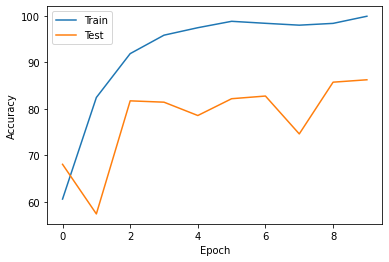

In [110]:
plt.plot(train_accuracy, label="Train")
plt.plot(test_accuracy, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()